In [1]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({"text.usetex": True,
                     'text.latex.preamble' : r'\usepackage{amsmath,amssymb}',
                    })
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats
import json
import utils
utils.set_fifth_range(14) # 2 diatonics above and below cente

from pathlib import Path

/home/chfin/Uni/phd/code/harmony-ornamentation/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plots

Plots of the model parameters for use in the paper.

## Loading Data

In [2]:
# load the data
def load_data(name):
    # chord types
    #df = utils.load_csv(path.join('data', name + '.tsv'))
    #sizes = df.groupby(['chordid', 'label']).size()
    #type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    #chordtypes = type_counts.index.tolist()
    
    # parameters
    with open(Path('results', name+'_params.json'), 'r') as f:
        data = json.load(f)
    
    return {k:np.array(v) for k,v in data['params'].items()}, np.array(data['chordtypes'], dtype='object')

In [3]:
dcml_params, dcml_chordtypes = load_data('dcml')
# wiki_params, wiki_chordtypes = load_data('wikifonia')
ewld_params, ewld_chordtypes = load_data('ewld')
fifth_range = 14

In [4]:
ewld_chordtypes

array(['major', 'dominant', 'minor', 'minor-seventh', 'major-seventh',
       'dominant-ninth', 'major-sixth', 'diminished', 'minor-sixth',
       'half-diminished', 'diminished-seventh', 'augmented-seventh',
       'suspended-fourth', 'augmented', 'dominant-13th', 'minor-ninth',
       'major-ninth', 'dominant-11th', 'major-minor', 'suspended-second',
       'minor-11th', 'power', 'major-13th', 'minor-13th'], dtype=object)

In [5]:
dcml_map = {
    'M': 'major',
    'm': 'minor',
    'o': 'diminished',
    '+': 'augmented',
    'Mm7': 'dominant-7th',
    'mm7': 'minor-7th',
    'MM7': 'major-7th',
    'mM7': 'minor-major-7th',
    '%7': 'half-diminished',
    'o7': 'full-diminished',
    '+7': 'augmented-7th',
    'Ger': 'German-6th',
    'It': 'Italian-6th',
    'Fr': 'French-6th',
}
dcml_chordtypes_alt = np.vectorize(dcml_map.get)(dcml_chordtypes)
ewld_map = {
    'major': 'major',
    'dominant': 'dominant-7th',
    'minor': 'minor',
    'minor-seventh': 'minor-7th',
    'major-seventh': 'major-7th',
    'dominant-ninth': 'dominant-9th',
    'major-sixth': 'major-6th',
    'diminished': 'diminished',
    'minor-sixth': 'minor-6th',
    'half-diminished': 'half-diminished',
    'diminished-seventh': 'full-diminished',
    'augmented-seventh': 'augmented-7th',
    'augmented': 'augmented',
    'suspended-fourth': 'suspended-4th',
    'dominant-13th': 'dominant-13th',
    'minor-ninth': 'minor-9th',
    'major-ninth': 'major-9th',
    'dominant-11th': 'dominant-11th',
    'major-minor': 'minor-major-7th',
    'suspended-second': 'suspended-2nd',
    'minor-11th': 'minor-11th',
    'power': 'power',
    'major-13th': 'major-13th',
    'minor-13th': 'minor-13th'
}
ewld_chordtypes_alt = np.vectorize(ewld_map.get)(ewld_chordtypes)
chordtypes_common = np.array(
    ["major", "minor", "dominant-7th", "diminished",
     "full-diminished", "minor-7th", "half-diminished", "major-7th",
     "augmented", "minor-major-7th", "augmented-7th"],
    dtype="object")
chordtypes_all = np.array(['major', 'minor', 'dominant-7th', 'diminished', 'full-diminished',
       'minor-7th', 'half-diminished', 'major-7th', 'augmented',
       'German-6th', 'Italian-6th', 'French-6th', 'minor-major-7th',
       'augmented-7th', 'dominant-9th', 'major-6th', 'minor-6th',
       'suspended-4th', 'dominant-13th', 'minor-9th',
       'major-9th', 'dominant-11th', 'power',
       'suspended-2nd', 'minor-11th', 'major-13th', 'minor-13th'],
      dtype=object)

In [6]:
def saveplot(name, fig):
    fig.savefig(Path('plots', name+'.pdf'))

## Posterior Plots

In [7]:
# posterior of 'rate_notes'
def plot_note_rate_post(ax, params, width=None):
    alpha = params['alpha_rate_notes']
    beta = params['beta_rate_notes']
    mean, var = stats.gamma.stats(alpha, scale=1/beta)
    print(f"{mean=}, {var=}")
    
    if width == None:
        limits = stats.gamma.interval(.999999, alpha, scale=1/beta)
    else:
        limits = (mean-width/2, mean+width/2)
    
    x = np.linspace(limits[0], limits[1], 400)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    ax.plot(x, y)
    ax.set_xlim(limits)
    ax.set_xlabel('$\lambda$')

def plot_note_rates(params1, params2, width=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3), sharey=True)
    plot_note_rate_post(ax1, params1, width=width)
    ax1.set_title("ABC+")
    plot_note_rate_post(ax2, params2, width=width)
    ax2.set_title("EWLD")
    fig.tight_layout()
    return fig

mean=6.592250601258104, var=5.791303954070964e-05
mean=2.3228371618234074, var=1.2267494280380265e-05


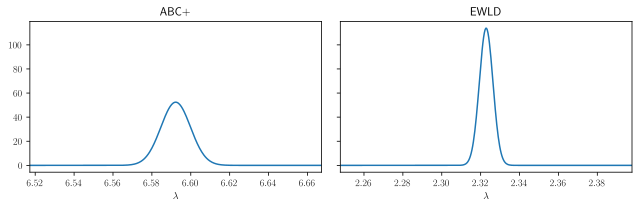

In [8]:
note_rates = plot_note_rates(dcml_params, ewld_params, width=0.15)
saveplot('note_rates', note_rates)

In [9]:
# zoom effect
def connect_bbox(bbox1, bbox2, bbox3,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
        }

    c1 = BboxConnector(bbox1, bbox3, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox3, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)
    bbox_patch1.set_clip_on(False)
    bbox_patch2.set_clip_on(False)

    p = BboxConnectorPatch(bbox1, bbox3,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p
    
def zoom_effect(ax1, ax2, xmin, xmax, **kwargs):
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, -0.12)
    bbox2 = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)
    mybbox3 = TransformedBbox(bbox2, trans2)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}#, "fc": "none"}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2, mybbox3,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect2(ax1, ax2, xmin, xmax):
    
    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)
    bbox = Bbox.from_extents(xmin, 0, xmax, -0.12)
    bbox2 = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)
    mybbox3 = TransformedBbox(bbox2, trans2)

    prop_patches = {"ec": "none", "alpha": 0.2}
    prop_lines = {"ec": 'black', 'fc': 'none', 'alpha': 0.5}

    c1 = BboxConnector(mybbox1, mybbox3, loc1=3, loc2=2, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(mybbox1, mybbox3, loc1=4, loc2=1, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(mybbox1, **prop_patches)
    bbox_patch2 = BboxPatch(mybbox2, **prop_patches)
    bbox_patch3 = BboxPatch(mybbox3, **prop_lines)
    bbox_patch1.set_clip_on(False)
    bbox_patch2.set_clip_on(False)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(bbox_patch3)
    ax2.add_patch(c1)
    ax2.add_patch(c2)

    return c1, c2, bbox_patch1, bbox_patch2

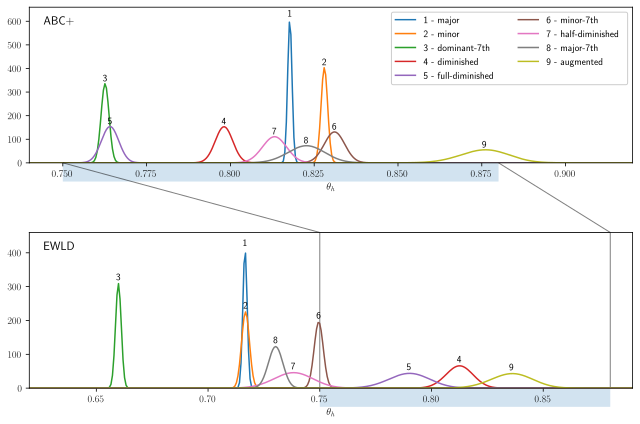

In [10]:
# posterior of 'p_is_chordtone'
def plot_p_ict(ax, params, harmtypes, indices, lower=0, upper=1):
    alphas = np.array(params["alpha_p_ict"])[indices]
    betas  = np.array(params["beta_p_ict"])[indices]
    x = np.linspace(lower, upper, 400)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    ax.plot(x,y)
    
    meansx = [stats.beta.mean(a,b) for a,b in zip(alphas,betas)]
    meansy = [stats.beta.pdf(x,a,b) for (x,a,b) in zip(meansx,alphas,betas)]
    for i,(xi,yi) in enumerate(zip(meansx,meansy)):
        ax.text(xi, yi+10, str(i+1), ha='center')
    
    ax.set_xlabel("$\\theta_h$")
    ax.set_xlim((lower, upper))
    ax.set_ylim((0,np.array(meansy).max()+50))

def plot_p_icts():
    selection_dcml = [np.where(dcml_chordtypes_alt == label)[0][0] for label in chordtypes_common[:-2]] # range(9)
    #selection_wiki = [0,2,1,7,11,3,9,4,13]
    selection_ewld = [np.where(ewld_chordtypes_alt == label)[0][0] for label in chordtypes_common[:-2]] # [0,2,1,7,10,3,9,4,12]
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(9,6))
    
    plot_p_ict(ax1, dcml_params, dcml_chordtypes_alt, selection_dcml,
               lower=0.74, upper=0.92)
    ax1.set_title('ABC+', x=0.05, y=0.85)
        
    plot_p_ict(ax2, ewld_params, ewld_chordtypes_alt, selection_ewld,
               lower=0.62, upper=0.89)
    ax2.set_title('EWLD', x=0.05, y=0.85)
    
    ax1.legend([f"{i+1} - {dcml_chordtypes_alt[l]}" for (i,l) in enumerate(selection_dcml)],
               loc='upper right', ncol=2, framealpha=1)
    
    zoom_effect2(ax1,ax2,0.75,0.88)
    fig.tight_layout()
    return fig

icts = plot_p_icts()
saveplot('icts', icts)

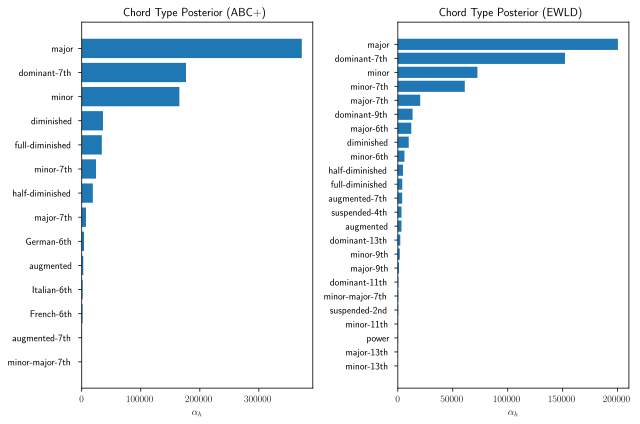

In [11]:
# posterior of chord type probabilities
def plot_chord_type_dist(ax, params, labels):
    alphas = params['params_p_harmony']
    ax.barh(np.arange(len(alphas))[::-1], alphas, tick_label=labels)
    ax.set_xlabel("$\\alpha_h$")
    
def plot_chord_type_dists():
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,6))
    plot_chord_type_dist(ax1, dcml_params, dcml_chordtypes_alt)
    ax1.set_title("Chord Type Posterior (ABC+)")
    plot_chord_type_dist(ax2, ewld_params, ewld_chordtypes_alt)
    ax2.set_title("Chord Type Posterior (EWLD)")
    fig.tight_layout()
    return fig
    
type_dist = plot_chord_type_dists()
saveplot('type_dist', type_dist)

In [12]:
interval_labels = ['dd1', 'dd5', 'd2', 'd6', 'd3', 'd7', 'd4',
                   'd1', 'd5', 'm2', 'm6', 'm3', 'm7', 'P4',
                   'P1', 'P5', 'M2', 'M6', 'M3', 'M7', 'a4',
                   'a1', 'a5', 'a2', 'a6', 'a3', 'a7', 'aa4', 'aa1']

def plot_profile(ax, params, i, name):
    chordtones = params['params_p_chordtones'][i]
    ornaments = params['params_p_ornaments'][i]
    #labels = [str(pitchtypes.SpelledIntervalClass(i)) for i in range(-fifth_range, fifth_range+1)]
    #labels = np.arange(-fifth_range, fifth_range+1)
    labels = interval_labels
    x = np.arange(2*fifth_range+1)
    width = 0.4
    ax.bar(x - width/2, chordtones, width, label='chord tones')
    ax.bar(x + width/2, ornaments, width, label='ornaments')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation='vertical', va='top', family='monospace', usetex=False, size='small')
    ax.set_xlim((-1,2*fifth_range+1))
    #ax.legend()

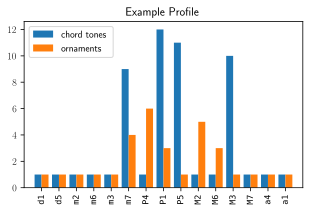

In [13]:
def plot_example_profile():
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    labels = interval_labels[7:22]
    chordtones = [1, 1, 1, 1, 1, 9, 1, 12, 11, 1, 1, 10, 1, 1, 1]
    ornaments = [1, 1, 1, 1, 1, 4, 6, 3, 1, 5, 3, 1, 1, 1, 1]
    x = np.arange(15)
    width=0.4
    ax.bar(x - width/2, chordtones, width, label='chord tones')
    ax.bar(x + width/2, ornaments, width, label='ornaments')
    ax.set_title("Example Profile")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation='vertical', va='top', family='monospace', usetex=False, size='small')
    ax.set_xlim((-1,15))
    ax.legend()
    return fig
    
example_profile = plot_example_profile()
saveplot('example_profile', example_profile)

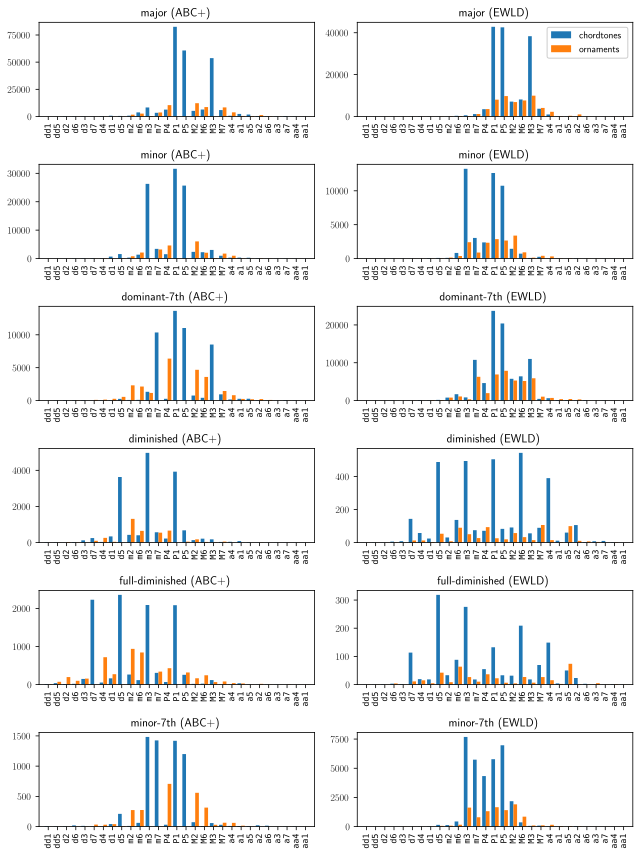

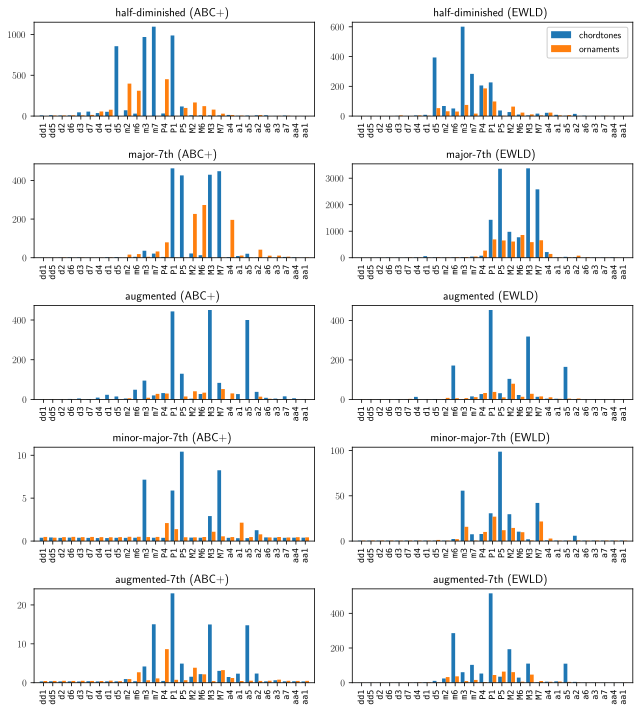

In [14]:
# posteriors of note probabilities (for common chord types)
def plot_common_chords(indices):
    fig, axs = plt.subplots(len(indices), 2, figsize=(9,len(indices)*2))
    for i, ind in enumerate(indices):
        name = chordtypes_common[ind]
        plot_profile(axs[i,0], dcml_params, np.where(dcml_chordtypes_alt == name)[0][0], name+" (ABC+)")
        plot_profile(axs[i,1], ewld_params, np.where(ewld_chordtypes_alt == name)[0][0], name+" (EWLD)")
    axs[0,1].legend(labels=['chordtones', 'ornaments'], framealpha=1)
    fig.tight_layout()
    return fig
        
common1 = plot_common_chords([0,1,2,3,4,5])
saveplot('chordtypes_common1', common1)
common2 = plot_common_chords([6,7,8,9,10])
saveplot('chordtypes_common2', common2)

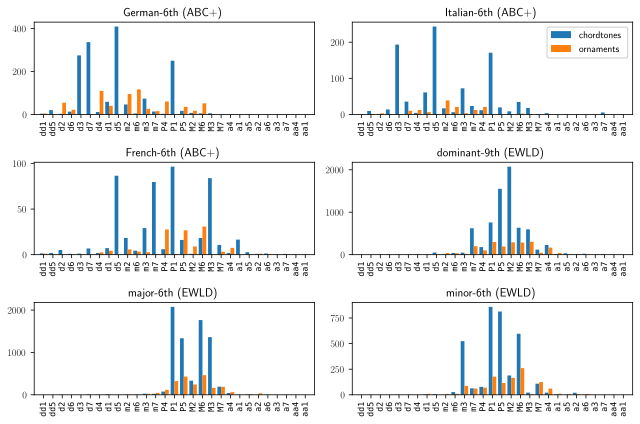

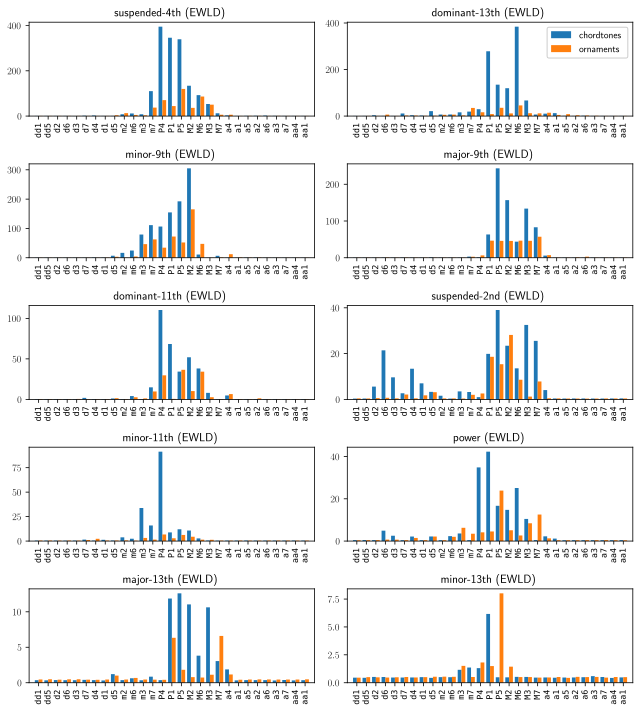

In [15]:
#plot remaining chords
def plot_rest_chords():
    rest_dcml = np.where(~(np.isin(dcml_chordtypes_alt, chordtypes_common)))[0]
    rest_wiki = np.where(~(np.isin(ewld_chordtypes_alt, chordtypes_common)))[0]
    
    #plot part 1
    fig1, axs1 = plt.subplots(3, 2, figsize=(9, 6))
    for i in range(3):
        ind = rest_dcml[i]
        plot_profile(axs1.flat[i], dcml_params, ind, dcml_chordtypes_alt[ind]+" (ABC+)")
    for i in range(3):
        ind = rest_wiki[i]
        plot_profile(axs1.flat[i+3], ewld_params, ind, ewld_chordtypes_alt[ind]+" (EWLD)")
    axs1[0,1].legend(labels=['chordtones', 'ornaments'], framealpha=1)
    fig1.tight_layout()
    saveplot('chordtypes_rest1', fig1)
    
    # plot part 2
    fig2, axs2 = plt.subplots(5, 2, figsize=(9, 10))
    for i in range(10):
        ind = rest_wiki[i+3]
        plot_profile(axs2.flat[i], ewld_params, ind, ewld_chordtypes_alt[ind]+" (EWLD)")
    axs2[0,1].legend(labels=['chordtones', 'ornaments'], framealpha=1)
    fig2.tight_layout()
    saveplot('chordtypes_rest2', fig2)

plot_rest_chords()

In [16]:
def plot_profile_small(ax, params, i, name):
    chordtones = params['params_p_chordtones'][i]
    ornaments = params['params_p_ornaments'][i]
    labels = np.arange(-fifth_range, fifth_range+1)
    x = np.arange(2*fifth_range+1)
    vals = np.stack([-chordtones, ornaments])
    extr = max(chordtones.max(), ornaments.max())
    ax.imshow(vals, cmap="bwr", vmin=-extr, vmax=extr)
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    #ax.legend()

## Clustering

In [17]:
data_path = Path('results', 'clustering')
device = 'cpu'

def mean_dist(X,Y):
    return abs(stats.beta.mean(X[0],X[1]) - stats.beta.mean(Y[0],Y[1]))

def replay_clustering(name, nharms, dist=mean_dist):
    # initial clustering
    cluster_assignment = dict((i,i) for i in range(nharms))

    # run iterative experiments
    outputs = []
    
    for it in range(nharms):
        nclusters = nharms - it
        print(f"iteration {it} ({nclusters} clusters).")
        print(cluster_assignment)
        
        # inference
        params_load = torch.load(data_path / f"{name}_params{nclusters}.pt")
        params = dict((n, torch.tensor(vals, device=device)) for n, vals in params_load.items())
        
        # record output
        outputs.append(dict({
            "params": params,
            "cluster_assignment": cluster_assignment,
        }))
        
        # compute next clustering / init
        if nclusters > 1:
            # find closest clusters
            alphas = params["alpha_p_ict"]
            betas = params["beta_p_ict"]
            dists = dict()
            for i in range(nclusters):
                for j in range(i+1, nclusters):
                    dists[(i,j)] = dist((alphas[i], betas[i]), (alphas[j], betas[j]))
            min1, min2 = min(dists, key=dists.get)

            # map clusters
            remaining = [i for i in range(nclusters) if i not in [min1,min2]]
            cluster_mapping = {**{min1: 0, min2: 0}, **dict((c,i+1) for i,c in enumerate(remaining))}
            
            # update assignment
            cluster_assignment = dict((h,cluster_mapping[c]) for h,c in cluster_assignment.items())

    return outputs

def load_cluster_params(name):
    with open(data_path / f"bf_{name}.json", 'r') as f:
        data = json.load(f)
    return data['chordtypes'], data['params']['params_model']

In [18]:
# the two datasets use a different order of chord types
dcml_chordtypes_common, dcml_cluster_probs = load_cluster_params('dcml')
dcml_outputs = replay_clustering("dcml", 9)
ewld_chordtypes_common, ewld_cluster_probs = load_cluster_params('ewld')
ewld_outputs = replay_clustering("ewld", 9)

iteration 0 (9 clusters).
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
iteration 1 (8 clusters).
{0: 1, 1: 0, 2: 2, 3: 3, 4: 0, 5: 4, 6: 5, 7: 6, 8: 7}
iteration 2 (7 clusters).
{0: 0, 1: 1, 2: 2, 3: 3, 4: 1, 5: 4, 6: 0, 7: 5, 8: 6}
iteration 3 (6 clusters).
{0: 1, 1: 2, 2: 0, 3: 3, 4: 2, 5: 0, 6: 1, 7: 4, 8: 5}
iteration 4 (5 clusters).
{0: 0, 1: 2, 2: 1, 3: 3, 4: 2, 5: 1, 6: 0, 7: 0, 8: 4}
iteration 5 (4 clusters).
{0: 0, 1: 1, 2: 0, 3: 2, 4: 1, 5: 0, 6: 0, 7: 0, 8: 3}
iteration 6 (3 clusters).
{0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 2}
iteration 7 (2 clusters).
{0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0}
iteration 8 (1 clusters).
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
iteration 0 (9 clusters).
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
iteration 1 (8 clusters).
{0: 0, 1: 1, 2: 0, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}
iteration 2 (7 clusters).
{0: 1, 1: 2, 2: 1, 3: 0, 4: 3, 5: 4, 6: 0, 7: 5, 8: 6}
iteration 3 (6 clusters).
{0

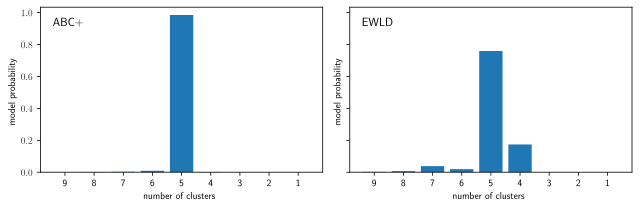

In [19]:
def plot_cluster_probs(probs, name, ax):
    n = len(probs)
    ax.bar([f"{n-i}" for i in range(n)], probs)
    #sns.barplot(x=, y=probs, ax=ax)
    ax.set_xlabel('number of clusters')
    ax.set_ylabel('model probability')
    ax.set_title(name, x=0.1, y=0.85)

def plot_all_cluster_probs():
    fig, ax = plt.subplots(1, 2, figsize=(9,3), sharey=True)
    plot_cluster_probs(dcml_cluster_probs, "ABC+", ax[0])
    plot_cluster_probs(ewld_cluster_probs, "EWLD", ax[1])
    fig.tight_layout()
    saveplot("cluster-probs", fig)
    plt.show(block=False)
    
plot_all_cluster_probs()

In [20]:
dcml_best_i, dcml_best_p = max(enumerate(dcml_cluster_probs), key=lambda x: x[1])
dcml_best_cluster = dcml_outputs[dcml_best_i]
ewld_best_i, ewld_best_p = max(enumerate(ewld_cluster_probs), key=lambda x: x[1])
ewld_best_cluster = ewld_outputs[ewld_best_i]
print(f"ABC+: {9-dcml_best_i} clusters, p={dcml_best_p}")
print(f"EWLD: {9-ewld_best_i} clusters, p={ewld_best_p}")

ABC+: 5 clusters, p=0.9848841557672179
EWLD: 5 clusters, p=0.7593494969337719


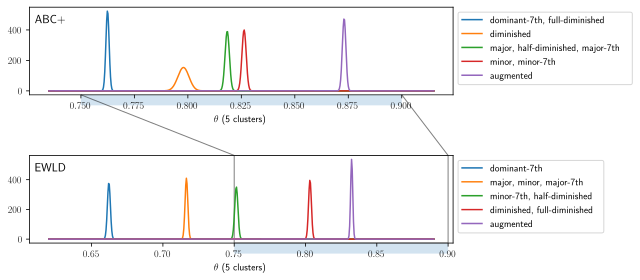

In [21]:
def plot_p_ict_cluster(ax, params, harmtypes, cluster_assignment, lower=0, upper=1):
    alphas = params["alpha_p_ict"]
    betas  = params["beta_p_ict"]
    #x = np.linspace(lower, upper, 600)
    #y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    means = alphas / (alphas + betas)
    
    # compute cluster names from assignment
    names = dict() # cluster index -> list of chord types
    for chord, cluster in cluster_assignment.items():
        name = harmtypes[chord]
        if(names.get(cluster) == None):
            names[cluster] = []
        names[cluster].append(name)
    # sort by cluster index
    its = sorted(names.items())
    name_labels = [str.join(", ",it[1]) for it in its]
    
    # combine all data and sort by cluster mean
    data = pd.DataFrame({"alpha": alphas, "beta": betas, "names": name_labels, "mean": means})
    data = data.sort_values("mean")
    x = np.linspace(lower, upper, 600)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(data.alpha, data.beta)]).transpose()
    
    # plot
    ax.plot(x,y)
    ax.set_xlabel(f"$\\theta$ ({len(set(cluster_assignment.values()))} clusters)")
    ax.legend(data.names, bbox_to_anchor=(1., 1),
              loc='upper left')

def plot_p_icts_clusters(dcml_cluster, ewld_cluster):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(9,4))
    
    plot_p_ict_cluster(ax1, dcml_cluster['params'], dcml_chordtypes_common, dcml_cluster['cluster_assignment'],
                       lower=0.735, upper=0.915)
    ax1.set_title('ABC+', x=0.05, y=0.75)
        
    plot_p_ict_cluster(ax2, ewld_cluster['params'], ewld_chordtypes_common, ewld_cluster['cluster_assignment'],
                       lower=0.62, upper=0.89)
    ax2.set_title('EWLD', x=0.05, y=0.75)
    
#     ax1.legend([f"{i+1} - {dcml_chordtypes_alt[i]}" for i in selection_dcml],
#                loc='upper right', ncol=2, framealpha=1)
    
    zoom_effect2(ax1,ax2,0.75,0.9)
    fig.tight_layout()
    return fig

clusters_plot = plot_p_icts_clusters(dcml_best_cluster, ewld_best_cluster)
saveplot('clusters', clusters_plot)

In [22]:
# for script mode
plt.show()